In [1]:
# Examples from Almond et al., 2015: Bayesian Networks in Educational Assessment, Ch6. Ex 6.1;  http://ecd.ralmond.net/ecdwiki/BN/IRT

In [2]:
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation

# IRT (1PL Rash model) probabilities for item

In [3]:

thetas = {-2: 0.1, -1: 0.2, 0: 0.4, 1: 0.2, 2: 0.1}
diffs = [-1.5, -0.75, 0, 0.75, 1.5]

def rasch_res(theta, diff):
    """
    Simple Rasch model
    - Discritized proficiency: theta
    -- e.g., discritized into 5 levels (-2, -1, 0, 1, 2), triangular distribution (0.1, 0.2, 0.4, 0.2, 0.1)
    - Difficulty: diff
    -- e.g., difficulty increases from item 1 to item 5 (-1.5, -0.75, 0, 0.75, 1.5)
    """
    return 1/(1 + np.exp(-1 * (theta - diff)))

In [4]:
def item_rasch_cpd(name_item, name_skill, thetas, diff):
    """
    Create TabularCPD (Conditional Probability Distribution) object for a question item using Rasch model
    Each item takes theta parameters, and single difficulty parameter to calculate correct/incorrect probability
    - thetas: dict(theta_param: prob)
    - diff: float
    """
    item_probs = np.array([
        [(1-rasch_res(t_d, diff)) * t_p for t_d, t_p in thetas.items()],  # theta probability
        [(  rasch_res(t_d, diff)) * t_p for t_d, t_p in thetas.items()]   # correct probability
    ])
    item_cpd = TabularCPD(
        variable=name_item, 
        variable_card=2,
        values=item_probs,
        evidence=[name_skill],
        evidence_card=[len(thetas)],
        state_names = {
            name_skill: list(thetas.keys()),
            name_item: ['Incorrect', 'Correct']
        }
    )
    return item_cpd


In [5]:
# testing the output: if difficulty = 0
print(item_rasch_cpd('item1', 'skill1', thetas, 0))

+------------------+----------------------+----------------------+-----------+----------------------+----------------------+
| skill1           | skill1(-2)           | skill1(-1)           | skill1(0) | skill1(1)            | skill1(2)            |
+------------------+----------------------+----------------------+-----------+----------------------+----------------------+
| item1(Incorrect) | 0.08807970779778825  | 0.14621171572600097  | 0.2       | 0.053788284273999024 | 0.011920292202211769 |
+------------------+----------------------+----------------------+-----------+----------------------+----------------------+
| item1(Correct)   | 0.011920292202211755 | 0.053788284273999024 | 0.2       | 0.14621171572600097  | 0.08807970779778823  |
+------------------+----------------------+----------------------+-----------+----------------------+----------------------+


# IRT Bayes Net

## Initialize the Bayesian network model structure
- You can either compose or import directed `networkx` graph object

In [6]:
# initialize the Bayesian network model structure as networkx object
name_skill = 'Skill1'
name_items = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5']

model_nx = nx.DiGraph()
model_nx.add_nodes_from([name_skill] + name_items)
model_nx.add_edges_from([(name_skill, item) for item in name_items])


## `networkx` object -> `pgmpy` Bayesian model

In [7]:
# copy edges
model_pgmpy = BayesianModel()
model_pgmpy.add_edges_from(model_nx.edges)

# CPD for skill
cpd_skill1 = TabularCPD(
    variable='Skill1', 
    variable_card=len(thetas),
    values=[[t_p] for t_p in thetas.values()])

model_pgmpy.add_cpds(cpd_skill1)

for name_item, diff in zip(name_items, diffs):
    # difficulty increases in the later item
    cpd_item = item_rasch_cpd(name_item, name_skill, thetas, diff)
    cpd_item.normalize()
    model_pgmpy.add_cpds(cpd_item)

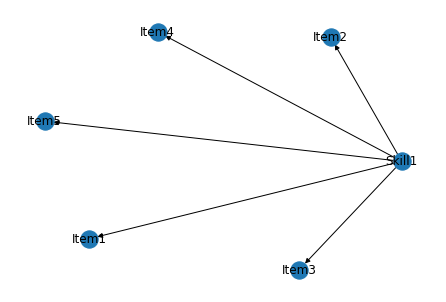

In [8]:
nx.draw(model_pgmpy, with_labels=True)

# Inference examples 

In [9]:
# Using BeliefPropagation for exact inferece; look for pgmpy's page for other exact/approximate inference methods
infer = BeliefPropagation(model_pgmpy)

## Marginal distributions

+------------+---------------+
| Skill1     |   phi(Skill1) |
+============+===============+
| Skill1(-2) |        0.1000 |
+------------+---------------+
| Skill1(-1) |        0.2000 |
+------------+---------------+
| Skill1(0)  |        0.4000 |
+------------+---------------+
| Skill1(1)  |        0.2000 |
+------------+---------------+
| Skill1(2)  |        0.1000 |
+------------+---------------+


Text(0.5, 1.0, 'Skill1 Thetas')

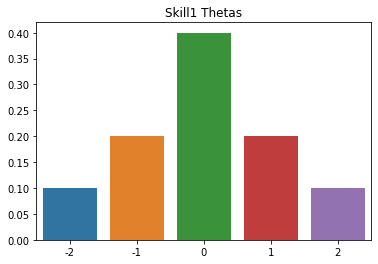

In [10]:
# marginal distribution for theta
res_marginal_skill1 = infer.query(['Skill1'], show_progress=False)
print(res_marginal_skill1)

sns.barplot(
    x=list(res_marginal_skill1.state_names.values())[0], 
    y=res_marginal_skill1.values,
)
plt.title("Skill1 Thetas")

+------------+---------------+
| Skill1     |   phi(Skill1) |
+============+===============+
| Skill1(-2) |        0.1000 |
+------------+---------------+
| Skill1(-1) |        0.2000 |
+------------+---------------+
| Skill1(0)  |        0.4000 |
+------------+---------------+
| Skill1(1)  |        0.2000 |
+------------+---------------+
| Skill1(2)  |        0.1000 |
+------------+---------------+


Text(0.5, 1.0, 'Item1 Probs')

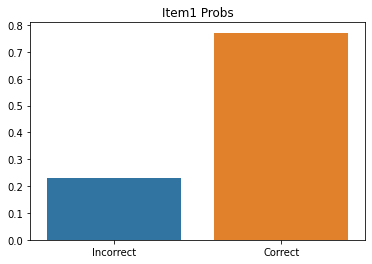

In [11]:
# marginal distribution for item1: 
res_marginal_item1 = infer.query(['Item1'], show_progress=False)
print(res_marginal_skill1)

sns.barplot(
    x=list(res_marginal_item1.state_names.values())[0], 
    y=res_marginal_item1.values
)
plt.title("Item1 Probs")

## Inference with evidence

In [12]:
# What happens to Skill1's theta values when correct responses are observed
## ex1. If item2 and item3 are correct
res_evidence_skill1_1 = infer.query(
    variables=['Skill1'],
    evidence={
        'Item1': 'Correct',
        'Item2': 'Correct',
    },
    show_progress=False
)

print(res_evidence_skill1_1)

+------------+---------------+
| Skill1     |   phi(Skill1) |
+============+===============+
| Skill1(-2) |        0.0158 |
+------------+---------------+
| Skill1(-1) |        0.1021 |
+------------+---------------+
| Skill1(0)  |        0.4162 |
+------------+---------------+
| Skill1(1)  |        0.2950 |
+------------+---------------+
| Skill1(2)  |        0.1709 |
+------------+---------------+


In [13]:
## ex2. If item4 and item5 are correct: more difficult items
res_evidence_skill1_2 = infer.query(
    variables=['Skill1'],
    evidence={
        'Item4': 'Correct',
        'Item5': 'Correct',
    },
    show_progress=False
)

print(res_evidence_skill1_2)

+------------+---------------+
| Skill1     |   phi(Skill1) |
+============+===============+
| Skill1(-2) |        0.0015 |
+------------+---------------+
| Skill1(-1) |        0.0193 |
+------------+---------------+
| Skill1(0)  |        0.2007 |
+------------+---------------+
| Skill1(1)  |        0.3639 |
+------------+---------------+
| Skill1(2)  |        0.4147 |
+------------+---------------+


- Item difficulty affects the SKill1's proficiency (*theta*) inference results
    - Correct responses from Item4 and 5 leads to higher *theta* posterior score than correct responses from Item1 and 2 

Text(0.5, 1.0, 'Skill1 Thetas update: If Item4 & 5 are correct')

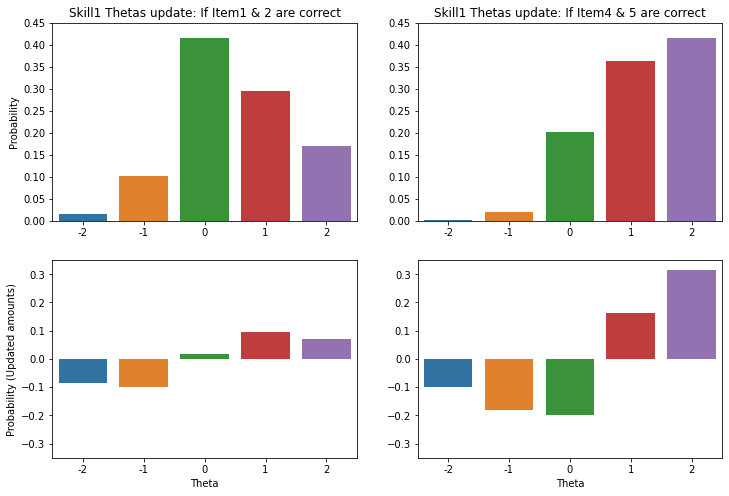

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# updated posteriors
for i, res in enumerate([res_evidence_skill1_1, res_evidence_skill1_2]):
    sns.barplot(
        x=list(res.state_names.values())[0], 
        y=res.values,
        ax=axes[0][i]
    )
    axes[0][i].set_ylim(0, 0.45)
axes[0][0].set_ylabel("Probability")

# difference from the marginal probs
for i, res in enumerate([res_evidence_skill1_1, res_evidence_skill1_2]):
    sns.barplot(
        x=list(res.state_names.values())[0], 
        y=res.values - res_marginal_skill1.values,
        ax=axes[1][i]
    )
    axes[1][i].set_ylim(-0.35, 0.35)
    axes[1][i].set_xlabel('Theta')
axes[1][0].set_ylabel("Probability (Updated amounts)")

axes[0][0].set_title("Skill1 Thetas update: If Item1 & 2 are correct")
axes[0][1].set_title("Skill1 Thetas update: If Item4 & 5 are correct")
